In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read data
train = np.loadtxt('data/trainingIa.dat')
valid = np.loadtxt('data/validationIa.dat')
train_with_grad = np.loadtxt('data/trainingIb.dat')

x_train, y_train = train[:, 0], train[:, 1]
x_grad, y_grad, g_grad = train_with_grad[:, 0], train_with_grad[:, 1], train_with_grad[:, 2]
x_valid, y_valid = valid[:, 0], valid[:, 1]

# Part 1 (a)

**Goal**
$$
\min \bigl\|\,V_\theta(x)-V(x)\,\bigr\|_2^2
\;\Longleftrightarrow\;
\min \bigl\|\mathbf{A}\theta-\mathbf{b}\bigr\|_2^2 .
$$

**Definitions**

Let
$$
\mathbf{b}=V(\mathbf{x})=\bigl(V(x_1),V(x_2),\dots,V(x_m)\bigr)^{\mathsf T}.
$$

Then $\mathbf{A}\theta = V_\theta(x)$
$$
V_\theta(\mathbf{x})=\sum_{j=1}^{n}\theta_j\,\phi_j(\mathbf{x})
= \sum_{j=1}^{n}\phi_j(\mathbf{x})\,\theta_j
= \Phi(\mathbf{x})^{\mathsf T}\theta .
$$

Hence set
$$
\mathbf{A}=\Phi(\mathbf{x})^{\mathsf T}=\bigl(\phi_1(\mathbf{x}),\phi_2(\mathbf{x}),\dots,\phi_n(\mathbf{x})\bigr),
$$
i.e.
$$
\mathbf{A}=
\begin{bmatrix}
\phi_1(x_1) & \phi_2(x_1) & \cdots & \phi_n(x_1)\\
\phi_1(x_2) & \phi_2(x_2) & \cdots & \phi_n(x_2)\\
\vdots      & \vdots      & \ddots & \vdots\\
\phi_1(x_m) & \phi_2(x_m) & \cdots & \phi_n(x_m)
\end{bmatrix}.
$$

Since $$\Phi(x)=(1,x,x^2,\dots,x^{n-1})$$, we have the Vandermonde form
$$
\mathbf{A}=
\begin{bmatrix}
1 & x_1 & x_1^2 & \cdots & x_1^{\,n-1}\\
1 & x_2 & x_2^2 & \cdots & x_2^{\,n-1}\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_m & x_m^2 & \cdots & x_m^{\,n-1}
\end{bmatrix},
\qquad
\mathbf{b}=
\begin{bmatrix}
V(x_1)\\
V(x_2)\\
\vdots\\
V(x_m)
\end{bmatrix}.
$$

**Least–squares solution**
$$
\;\theta_{\mathrm{LS}}=(\mathbf{A}^{\mathsf T}\mathbf{A})^{-1}\mathbf{A}^{\mathsf T}b\;
$$


In [2]:
def fit(n, x_train, y_train, x_valid, y_valid):
    """
    :param n: order
    :param x_train: training data - x
    :param y_train: training data - V(x)
    :param x_valid: validation data - x
    :param y_valid: validation data - V(x)
    """
    V = np.vander(x_train, N=n, increasing=True)
    theta = np.linalg.inv(V.T @ V) @ V.T @ y_train
    train_mse = np.mean((V @ theta - y_train)**2)
    V_theta = np.vander(x_valid, N=n, increasing=True) @ theta
    valid_mse = np.mean((V_theta - y_valid)**2)
    return theta, valid_mse, train_mse

n* = 10, MSE = 0.0008575889807280378
[10]


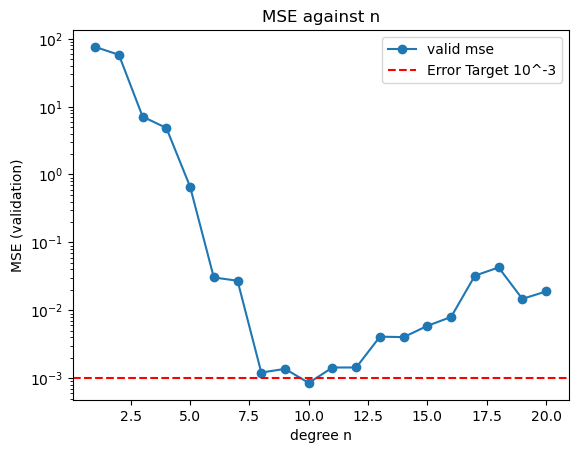

In [3]:
# check what number of degree n can reach the error < 1.0e-3
ns = np.arange(1, 21)
mses = []
thetas = {}
# n_optim = None
n_optim = None
n_optims = []
for n in ns:
    theta, valid_mse, train_mse = fit(n, x_train, y_train, x_valid, y_valid)
    if valid_mse < 1e-3:
        n_optim = n
        n_optims.append(n)
    mses.append(valid_mse)
    thetas[n] = theta
print(f"n* = {n_optim}, MSE = {mses[n_optim - 1] if n_optim else None}")
print(n_optims)

# plot the figure mse against degree n
plt.figure()
plt.yscale('log')
plt.plot(ns, mses, marker='o', label='valid mse')
plt.axhline(y=1e-3, linestyle='--', color='red', label='Error Target 10^-3')
plt.legend()
plt.xlabel('degree n')
plt.ylabel('MSE (validation)')
plt.title('MSE against n')
plt.show()

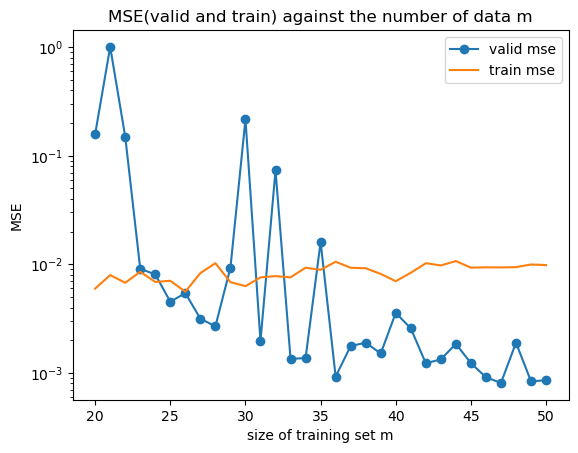

size of training set: 50


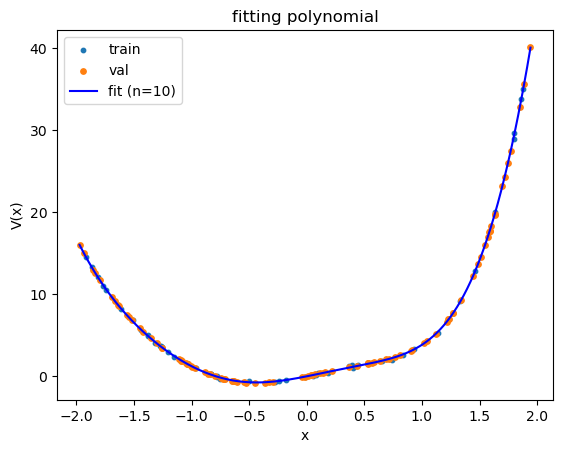

In [4]:
if n_optim is not None:
    m_all = len(x_train)
    sizes = range(20, m_all+1)
    valid_mses = []
    train_mses = []
    rng = np.random.default_rng(42)
    for mprime in sizes:
        idx = rng.choice(m_all, size=mprime, replace=False)
        theta, valid_mse, train_mse = fit(n_optim, x_train[idx], y_train[idx], x_valid, y_valid)
        valid_mses.append(valid_mse)
        train_mses.append(train_mse)
    plt.figure()
    plt.yscale('log')
    plt.plot(sizes, valid_mses, marker='o', label='valid mse')
    plt.plot(sizes, train_mses, label='train mse')
    plt.legend()
    plt.xlabel('size of training set m')
    plt.ylabel('MSE')
    plt.title('MSE(valid and train) against the number of data m')
    plt.show()

    print('size of training set:', m_all)

    theta = thetas[n_optim]
    grid = np.linspace(x_valid.min(), x_valid.max(), 400)
    yhat = np.vander(grid, n_optim, increasing=True) @ theta

    plt.figure()
    plt.scatter(x_train, y_train, s=10, label='train')
    plt.scatter(x_valid, y_valid, s=15, label='val')
    plt.plot(grid, yhat, label=f'fit (n={n_optim})', color='blue')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.title('fitting polynomial')
    plt.show()


# Part 1 (b)

Let $$\nabla V(x_i)=g_i.$$

**Goal**
$$
\min \|A\theta-b\|_2^2 \;+\; \lambda\,\|G\theta-g\|_2^2 .
$$

**Model**
$$
V_\theta(x)=\sum_{j=1}^{n}\theta_j\,\phi_j(x)=\sum_{j=1}^{n}\theta_j\,x^{\,j-1},
\qquad
\nabla V_\theta(x)=\sum_{j=1}^{n}\theta_j\,\nabla\phi_j(x)=\sum_{j=1}^{n}(j-1)\theta_j\,x^{\,j-2}.
$$

So, let
$$
G_{i,j}=(j-1)\,x_i^{\,j-2},
\qquad
G=
\begin{bmatrix}
0 & 1 & 2x_1 & 3x_1^2 & \cdots & (n-1)x_1^{\,n-2}\\
0 & 1 & 2x_2 & 3x_2^2 & \cdots & (n-1)x_2^{\,n-2}\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
0 & 1 & 2x_m & 3x_m^2 & \cdots & (n-1)x_m^{\,n-2}
\end{bmatrix},
\qquad
g=
\begin{bmatrix}
\nabla V(x_1)\\
\nabla V(x_2)\\
\vdots\\
\nabla V(x_m)
\end{bmatrix}.
$$

**Derivation**
$$
\min \|A\theta-b\|^2 + \lambda \|G\theta-g\|^2 \;=\; \min f(\theta),
$$
where
$$
f(\theta)=\theta^{\mathsf T}A^{\mathsf T}A\theta-2\,b^{\mathsf T}A\theta+\|b\|^2
\;+\;
\lambda\,\theta^{\mathsf T}G^{\mathsf T}G\theta-2\lambda\,g^{\mathsf T}G\theta+\lambda\|g\|^2.
$$
Thus
$$
\nabla f(\theta)=2A^{\mathsf T}A\theta-2A^{\mathsf T}b+2\lambda G^{\mathsf T}G\theta-2\lambda G^{\mathsf T}g=0,
$$
so
$$
\bigl(A^{\mathsf T}A+\lambda G^{\mathsf T}G\bigr)\theta
= A^{\mathsf T}b+\lambda G^{\mathsf T}g,
$$
and
$$
\theta_{\mathrm{LS}}
=\bigl(A^{\mathsf T}A+\lambda G^{\mathsf T}G\bigr)^{-1}\bigl(A^{\mathsf T}b+\lambda G^{\mathsf T}g\bigr).
$$


In [59]:
def fit_with_grad(n, x_grad, y_grad, g_grad, x_valid, y_valid, lamb=1.0):
    """
    :param n: order
    :param x_grad: training data - x
    :param y_grad: training data - V(x)
    :param g_grad: training data - V'(x)
    :param x_valid: validation data - x
    :param y_valid: validation data - V(x)
    :param lamb: lambda
    """
    V = np.vander(x_grad, N=n, increasing=True)
    G = np.zeros_like(V, dtype=V.dtype)
    for j in range(1, n):
        G[:, j] = j * x_grad ** (j - 1)
    lhs = V.T @ V + lamb * G.T @ G
    rhs = V.T @ y_grad + lamb * G.T @ g_grad
    theta = np.linalg.inv(lhs) @ rhs
    train_mse = np.mean((V @ theta - y_grad) ** 2) + lamb * np.mean((G @ theta - g_grad) ** 2)
    V_theta = np.vander(x_valid, N=n, increasing=True) @ theta
    valid_mse = np.mean((V_theta - y_valid) ** 2)
    return theta, valid_mse, train_mse

n* = 10, MSE = 0.0003358351358016279
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


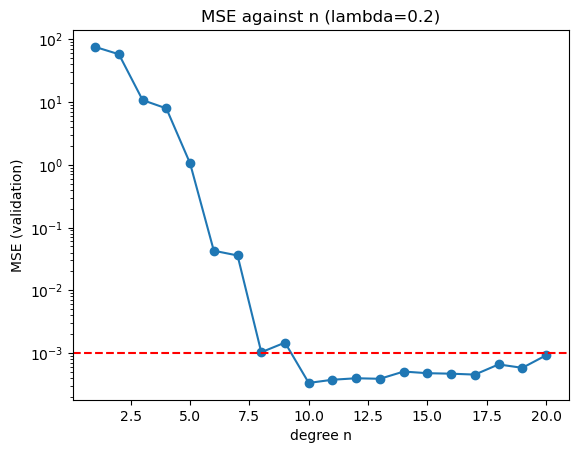

In [75]:
# check what number of degree n can reach the error < 1.0e-3
ns = np.arange(1, 21)
mses_grad = []
thetas_grad = {}
n_optim_grad = None
least_valid_mse = float('inf')
lamb = 0.2
n_optims_grad = []
for n in ns:
    theta_grad, valid_mse_grad, train_mse_grad = fit_with_grad(n, x_grad, y_grad, g_grad, x_valid, y_valid, lamb=lamb)
    if valid_mse_grad < 1e-3:
        n_optims_grad.append(n)
    if valid_mse_grad < least_valid_mse:
        n_optim_grad = n
        least_valid_mse = valid_mse_grad
    mses_grad.append(valid_mse_grad)
    thetas_grad[n] = theta_grad
print(f"n* = {n_optim_grad}, MSE = {mses_grad[n_optim_grad - 1] if n_optim_grad else None}")

print(n_optims_grad)

# plot the figure mse against degree n
plt.figure()
plt.yscale('log')
plt.plot(ns, mses_grad, marker='o')
plt.axhline(y=1e-3, linestyle='--', color='red')
plt.xlabel('degree n')
plt.ylabel('MSE (validation)')
plt.title(f'MSE against n (lambda={lamb})')
plt.show()

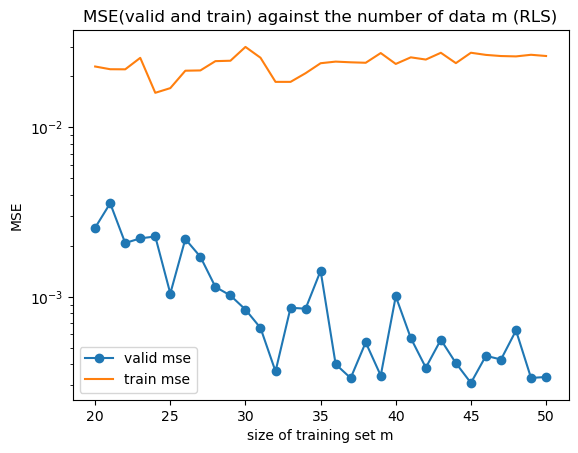

size of training set: 50
10


In [79]:
if n_optim_grad is not None:
    m_all = len(x_grad)
    sizes = range(20, m_all+1)
    valid_mses = []
    train_mses = []
    rng = np.random.default_rng(42)
    for mprime in sizes:
        idx = rng.choice(m_all, size=mprime, replace=False)
        theta, valid_mse, train_mse = fit_with_grad(n_optim_grad, x_grad[idx], y_grad[idx], g_grad[idx], x_valid, y_valid, 0.2)
        valid_mses.append(valid_mse)
        train_mses.append(train_mse)
    plt.figure()
    plt.yscale('log')
    plt.plot(sizes, valid_mses, marker='o', label='valid mse')
    plt.plot(sizes, train_mses, label='train mse')
    plt.legend()
    plt.xlabel('size of training set m')
    plt.ylabel('MSE')
    plt.title('MSE(valid and train) against the number of data m (RLS)')
    plt.show()

    print('size of training set:', m_all)
    print(n_optim_grad)



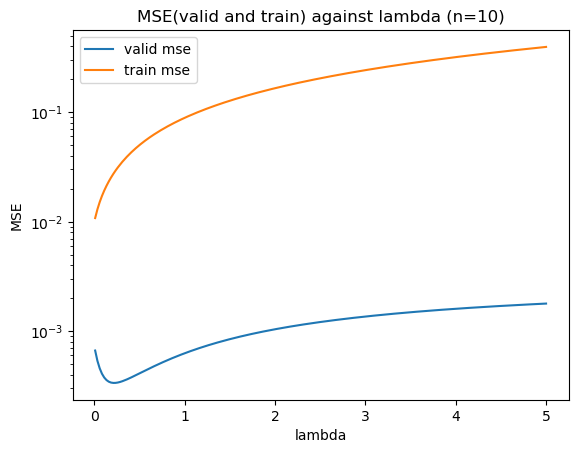

Best lambda: 0.2106
Best valid MSE: 0.000335


In [65]:
# MSE vs lambda (n=10)
m_all = len(x_train)
lambdas = np.linspace(0.01, 5, 200)
valid_mses = []
train_mses = []
n=10
for lamb in lambdas:
    _, valid_mse, train_mse = fit_with_grad(n, x_grad, y_grad, g_grad, x_valid, y_valid, lamb)
    valid_mses.append(valid_mse)
    train_mses.append(train_mse)
plt.figure()
plt.yscale('log')
plt.plot(lambdas, valid_mses, label='valid mse')
plt.plot(lambdas, train_mses, label='train mse')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title(f'MSE(valid and train) against lambda (n={n})')
plt.show()

min_idx = np.argmin(valid_mses)
best_lambda = lambdas[min_idx]
best_valid_mse = valid_mses[min_idx]

print(f'Best lambda: {best_lambda:.4f}')
print(f'Best valid MSE: {best_valid_mse:.6f}')

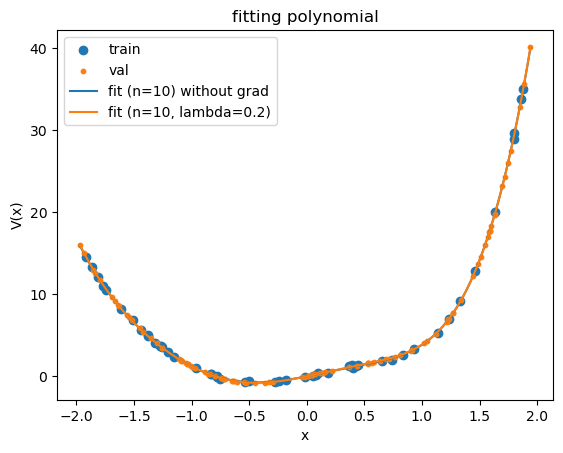

In [71]:
if n_optim_grad is not None:
    theta_grad = thetas_grad[n_optim_grad]
    grid = np.linspace(x_valid.min(), x_valid.max(), 400)
    yhat_grad = np.vander(grid, n_optim_grad, increasing=True) @ theta_grad
    theta = thetas[n_optim_grad]
    yhat = np.vander(grid, n_optim_grad, increasing=True) @ theta  

    plt.figure()
    plt.scatter(x_grad, y_grad, label='train')
    plt.scatter(x_valid, y_valid, s=10, label='val')
    plt.plot(grid, yhat, label=f'fit (n={n_optim_grad}) without grad')
    plt.plot(grid, yhat_grad, label=f'fit (n={n_optim_grad}, lambda={lamb})')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('V(x)')
    plt.title('fitting polynomial')
    plt.show()


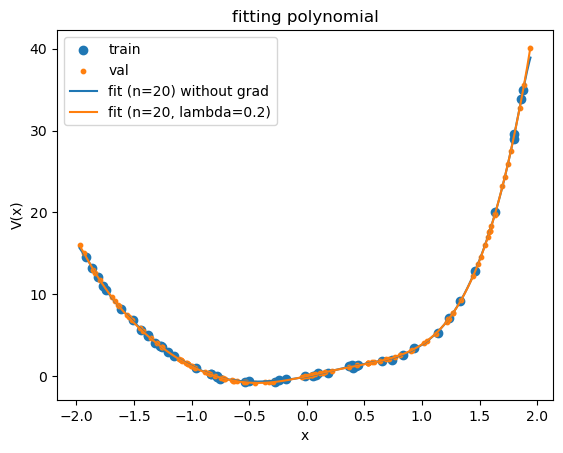

In [73]:
n_grad = 20
theta_grad = thetas_grad[n_grad]
grid = np.linspace(x_valid.min(), x_valid.max(), 400)
yhat_grad = np.vander(grid, n_grad, increasing=True) @ theta_grad

theta = thetas[n_grad]
yhat = np.vander(grid, n_grad, increasing=True) @ theta

plt.figure()
plt.scatter(x_grad, y_grad, label='train')
plt.scatter(x_valid, y_valid, s=10, label='val')

plt.plot(grid, yhat, label=f'fit (n={n_grad}) without grad')
plt.plot(grid, yhat_grad, label=f'fit (n={n_grad}, lambda={lamb})')

plt.legend()
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('fitting polynomial')
plt.show()